In [1]:
# Notebook setup
# Note these libraries are used by Sage's notebook Profile_Examples_for_WHOI.ipynb
import requests
import os
import re
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo
from netCDF4 import num2date

# libraries importate by Filipe in gist.ipynb
import ctd
import gsw
from ctd.read import _basename

# Make the Plots pretty
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 14})
# !!!!!! Note: I am running the notebooks on my local machine and thus do 
# not have to install netcdf4. Also I added cmocean to my environment. !!!!!!!!

# Load Data
Data has been requested by Stace already through the portal

October 2019 recovered

- Inshore water depth of 92 m
- Central inshore water depth of 126 m
- Central offshore water depth of 146 m
- Offshore water depth of 451 m
- Distance between inshore and central inshore 15.32 km, between central inshore and central offshore 14.47 km, between central offshore and offshore 17.91 km (link to cruise report)


In [2]:
# Provide URL to load a single file that has already been downloaded to OOI's OPENDAP server
# remember to use #fillmismatch
# Create directory that includes all urls
data_url = {}
data_url['inshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T132326640Z-CP03ISPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0003_CP03ISPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191006T150003-20191031T212239.977728.nc#fillmismatch'
data_url['central_inshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T132900316Z-CP02PMCI-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0013_CP02PMCI-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191007T210003-20191031T212442.986087.nc#fillmismatch'
data_url['central_offshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T133142674Z-CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0013_CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191008T140003-20191031T212529.983845.nc#fillmismatch'
data_url['offshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T133343088Z-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0012_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191013T160003-20191031T211622.990750.nc#fillmismatch'


In [3]:
# Load the data file using xarray
def load2xarray(location):
    """
    Load data at given location and reduce to variables of interest.
    """
    ds = xr.open_dataset(data_url[location])
    ds = ds.swap_dims({'obs': 'time'}) #Swap dimensions
    print('Dataset '+ location +' has %d points' % ds.time.size)
    ds = ds[['ctdpf_ckl_seawater_pressure','ctdpf_ckl_seawater_temperature','practical_salinity']]
    return ds

ds={}
for loc in list(data_url.keys()):
    ds[loc] = load2xarray(loc)

Dataset inshore has 158237 points
Dataset central_inshore has 210513 points
Dataset central_offshore has 236989 points
Dataset offshore has 199587 points


# Plot scatter time series

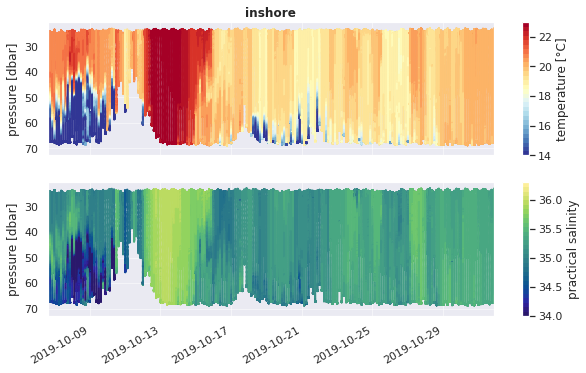

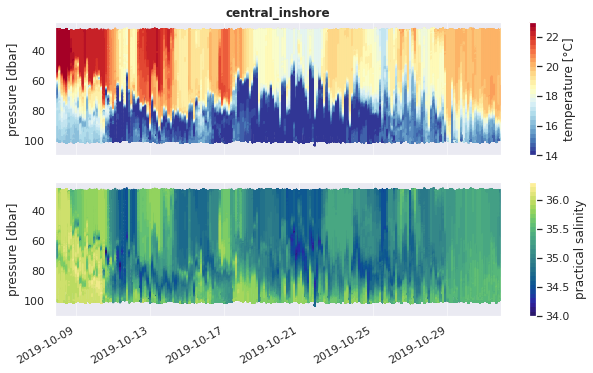

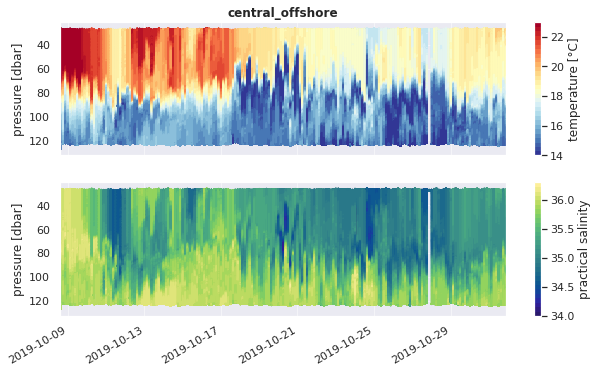

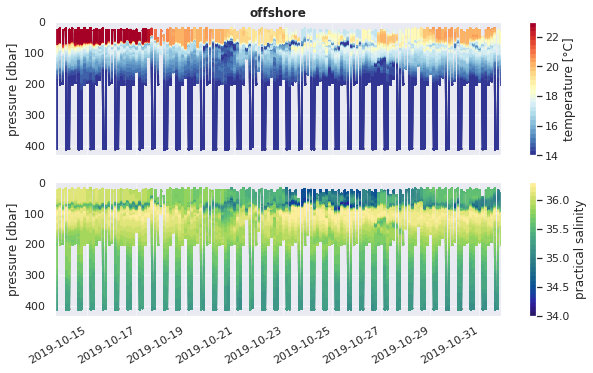

In [4]:
#####################################
# plotting function

def scatter_timeseries(ds,location=None):
    fig,ax = plt.subplots(figsize=(10,6),nrows=2,sharex=True,constrained_layout=False)
    cc = ax[0].scatter(ds.time,ds.ctdpf_ckl_seawater_pressure,s=1,
                    c=ds.ctdpf_ckl_seawater_temperature,
                    cmap = plt.get_cmap('RdYlBu_r',30),vmin=14,vmax=23)
    plt.colorbar(cc,ax=ax[0],label='temperature [\N{DEGREE SIGN}C]')
#     plt.xticks(rotation=30)
    ax[0].set_xlim(ds.time[0],ds.time[-1]) # Set the time limits to match the dataset


    cc = ax[1].scatter(ds.time,ds.ctdpf_ckl_seawater_pressure,s=1,
                    c=ds.practical_salinity,
                    cmap = plt.get_cmap('cmo.haline',30),vmin=34,vmax=36.3)
    plt.colorbar(cc,ax=ax[1],label='practical salinity')
#     plt.xticks(rotation=30)

    for axh in ax.flat: axh.set_ylabel('pressure [dbar]'); axh.invert_yaxis();
    if location: ax[0].set_title(location,fontweight='bold')
    fig.autofmt_xdate()

    return fig,ax

#######################################
# plot scatter timeseries for all locations
for loc in list(data_url.keys()):
    scatter_timeseries(ds[loc],loc)

# Extract downcast

In order to be able to plot a section we need individual profiles at each location at a given time. We cannot just resample by time because it is profiling data, which is not binned in vertical.  
A few steps I would take next:   
- extract the downcast only
- assign one time to each profile

**Splitting casts based on gradient in pressure**

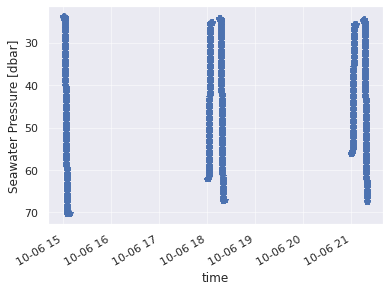

In [41]:
# plot first few profiles from initial dataset to test method

dummy = ds['inshore']
dummy.ctdpf_ckl_seawater_pressure[0:2000].plot(marker='*',linestyle='')
plt.gca().invert_yaxis()

We can see that there is always a downcast, followed by a time gap, then upcast and next downcast.

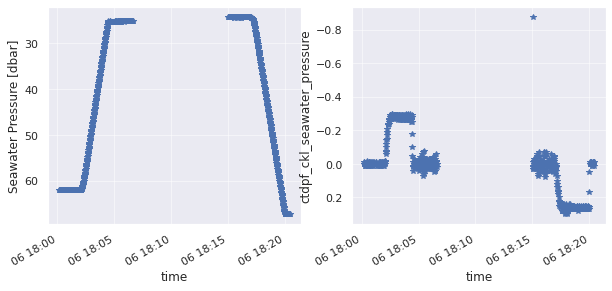

In [44]:
# plot a few casts
fig,ax = plt.subplots(ncols=2,figsize=(10,4))
dummy.ctdpf_ckl_seawater_pressure[500:1200].plot(marker='*',linestyle='',ax=ax[0])
ax[0].invert_yaxis()

# plot difference in pressure
dummy.ctdpf_ckl_seawater_pressure[500:1200].diff(dim='time').plot(marker='*',linestyle='',ax=ax[1])
ax[1].invert_yaxis()


Based on these plots I can apply a thresshold of 0.1 for diff(pressure). Tried 0.2 but then lose too much data.

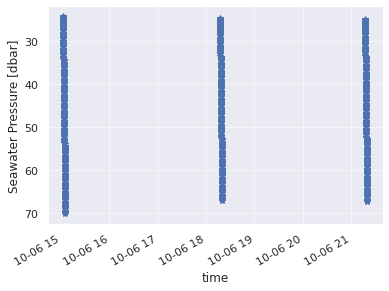

In [45]:
# select only data where pressure is increasing for downcast
downcast = dummy.where(dummy.ctdpf_ckl_seawater_pressure.diff(dim='time')>0.1)

# plot to check if it worked
downcast.ctdpf_ckl_seawater_pressure[0:2000].plot(marker='*',linestyle='')
plt.gca().invert_yaxis()


**SR: Seems to work sort of ok!**

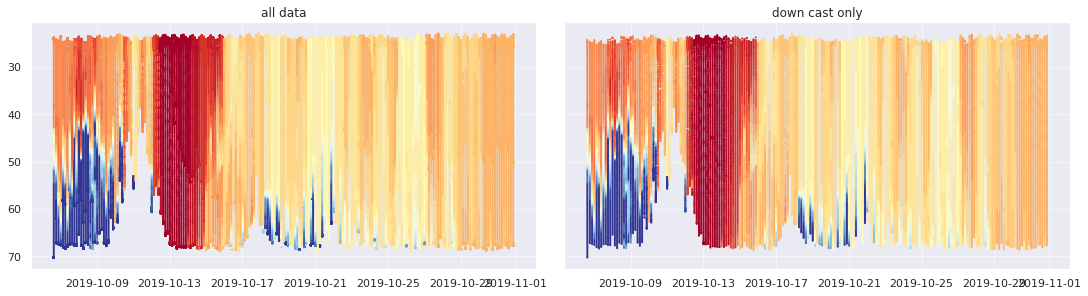

In [9]:
# plt scatter of old vs. new
fig,ax = plt.subplots(ncols=2,figsize=(15,4),sharey=True,constrained_layout=True)
ax[0].scatter(dummy.time,dummy.ctdpf_ckl_seawater_pressure,s=1,
                    c=dummy.ctdpf_ckl_seawater_temperature,
                    cmap = plt.get_cmap('RdYlBu_r',30),vmin=14,vmax=23)
ax[0].set_title('all data')
# ax[0].invert_yaxis()

ax[1].scatter(dummy_down.time,dummy_down.ctdpf_ckl_seawater_pressure,s=1,
                    c=dummy_down.ctdpf_ckl_seawater_temperature,
                    cmap = plt.get_cmap('RdYlBu_r',30),vmin=14,vmax=23)
ax[1].set_title('down cast only')
ax[1].invert_yaxis()


# Extract down/upcast or both

In [193]:
def get_cast(ctd:xr, cast:str = 'down'):
    """
    Extract downcast, upcast or both and assign a specific profile attribute based on the cast
    """
    
    if cast == 'up':
        # select only data where pressure is decreasing
        down = ctd.where((np.diff(ctd.ctdpf_ckl_seawater_pressure) < 0.1) &
                         (np.fabs(ctd.ctdpf_ckl_seawater_pressure.diff(dim = 'time')) > .1)).dropna(dim = 'time')
        # out = down.assign(ctdpf_ckl_cast=xr.ones_like(down['ctdpf_ckl_seawater_pressure']) * 1)
        out = down.assign(ctdpf_ckl_cast='upcast')
        return out
    
    if cast == 'down':        
        # select only data where pressure is increasing
        down = ctd.where(ctd.ctdpf_ckl_seawater_pressure.diff(dim = 'time') > 0.1).dropna(dim = 'time')
        # out = down.assign(ctdpf_ckl_cast=xr.ones_like(down['ctdpf_ckl_seawater_pressure']) * 2)
        out = down.assign(ctdpf_ckl_cast='downcast')
        return out
    
    if cast == 'full':
        down = ctd.where(((np.diff(ctd.ctdpf_ckl_seawater_pressure) < 0.1) &
                         (np.fabs(ctd.ctdpf_ckl_seawater_pressure.diff(dim = 'time')) > .1)) | 
                         (ctd.ctdpf_ckl_seawater_pressure.diff(dim = 'time') > 0.1)).dropna(dim = 'time')
        idx = np.where(np.diff(xr.concat([down.ctdpf_ckl_seawater_pressure[0], 
                                          down.ctdpf_ckl_seawater_pressure], dim='time')) > 0.1, 'downcast', 'upcast')
        out = down.assign(ctdpf_ckl_cast=xr.DataArray(idx, dims=["time"]))
        return out
    
    if cast not in ('up', 'down', 'full'):
        raise NameError(
            f'Expected cast name to be `up`, `down`, or `full`, instead got {cast}'
        )

### Function to plot the timeseries

In [32]:
def plot_cast(sds:xr, label:str, ax, c=None, cmap=None) -> None:
    
    if 'temp' in label:
        c = sds.ctdpf_ckl_seawater_temperature
        cmap = plt.get_cmap('cmo.thermal',30)
    
    if 'sal' in label:
        c = sds.practical_salinity
        cmap = plt.get_cmap('cmo.haline',30) 
        
    vmin, vmax = c.min(), c.max()
    s = ax.scatter(sds.time,
                   sds.ctdpf_ckl_seawater_pressure,
                   s=1, c=c, cmap=cmap, vmin=vmin, vmax=vmax)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(s, cax=cax, label=label)
    
    for tlab in ax.get_xticklabels():
        tlab.set_rotation(40)
        tlab.set_horizontalalignment('right')

## test how separation for upcast works

Text(0.5, 1.0, 'downcast')

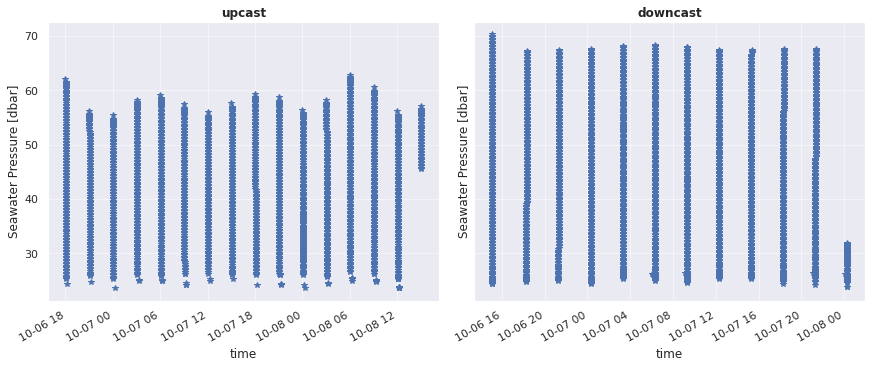

In [192]:
loc = 'inshore'

fig,ax = plt.subplots(figsize=(12,5),ncols=2,sharey=True,constrained_layout=True)
upcast1 = get_cast(ds[loc], cast='up')
downcast1 = get_cast(ds[loc], cast='down')

# plot
upcast1.ctdpf_ckl_seawater_pressure[0:2000].plot(marker='*',linestyle='',ax=ax[0])
ax[0].set_title('upcast',fontweight='bold')
downcast1.ctdpf_ckl_seawater_pressure[0:2000].plot(marker='*',linestyle='',ax=ax[1])
ax[1].set_title('downcast',fontweight='bold')


## Example with downcast

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs


ValueError: Could not convert object to NumPy datetime

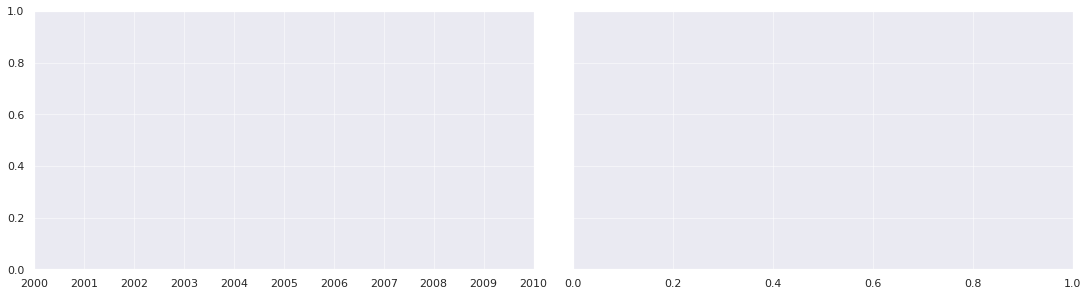

In [228]:
%time
downcast={}
cast = 'down'
for loc in list(data_url.keys())[:1]:
    downcast[loc] = get_cast(ds[loc], cast=cast)
    
    fig, ax = plt.subplots(ncols=2,figsize=(15,4), sharey=True, constrained_layout=True)
    plot_cast(sds=downcast[loc], 
              label='temperature [\N{DEGREE SIGN}C]', ax=ax[0])
    plot_cast(sds=downcast[loc], 
              label='practical salinity', ax=ax[1])
    
    ax[1].invert_yaxis()
    fig.suptitle(f"{loc} [{cast}cast only]", fontweight='bold')
    fig.autofmt_xdate()
    plt.subplots_adjust(hspace=0.5)

## Example with upcast

In [ ]:
%time
upcast={}
cast = 'up'
for loc in list(data_url.keys())[:1]:
    upcast[loc] = get_cast(ds[loc], cast=cast)
       
    # plt scatter of old vs. new
    fig, ax = plt.subplots(ncols=2,figsize=(15,4), sharey=True, constrained_layout=True)
    plot_cast(sds=upcast[loc], 
              label='temperature [\N{DEGREE SIGN}C]', ax=ax[0])
    plot_cast(sds=upcast[loc], 
              label='practical salinity', ax=ax[1])
    
    ax[1].invert_yaxis()
    fig.suptitle(f"{loc} [{cast}cast only]", fontweight='bold')
    fig.autofmt_xdate()
    plt.subplots_adjust(hspace=0.5)

**SR: Seems like upscast has definitely more gaps than downcast**

## Example with fullcast with intermittent values removed

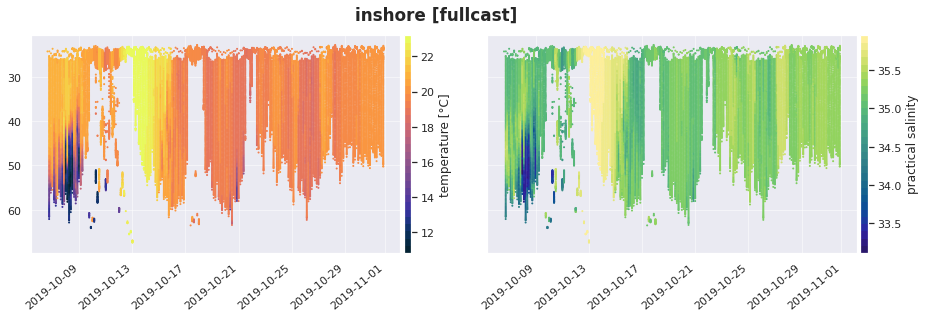

In [36]:
fullcast={}
cast = 'full'
for loc in list(data_url.keys())[:1]:
    fullcast[loc] = get_cast(ds[loc], cast=cast)
    
    fig, ax = plt.subplots(ncols=2,figsize=(15,4), sharey=True, constrained_layout=True)
    
    # display one of the casts just for comparison with previous
    sds = fullcast[loc].where(fullcast[loc].ctdpf_ckl_cast == 'upcast')
    plot_cast(sds=sds, 
              label='temperature [\N{DEGREE SIGN}C]', ax=ax[0])
    plot_cast(sds=sds, 
              label='practical salinity', ax=ax[1])
    
    ax[1].invert_yaxis()
    fig.suptitle(f"{loc} [{cast}cast]", fontweight='bold')
    fig.autofmt_xdate()
    plt.subplots_adjust(hspace=0.5)

# Perform vertical discretization of individual profiles
## Optionally, smooth the vertical profile

In [33]:
def profile_filt(data: dict, key: str, window_length: int, polyorder: int, profile_disp: bool) -> dict:
    """
    Profile smoothing using `savgol_filter`. In general `savgol_filter` produces good results compared to other 
    methods I have tried. For more, please check https://docs.scipy.org/doc/scipy/reference/signal.html
    """
    from scipy.signal import savgol_filter
    
    out = data
    out[key] = savgol_filter(data[key], window_length=window_length, polyorder=polyorder)
    
    if profile_disp is True:
        fig, ax = plt.subplots()
        ax.plot(out[key], data['pres'], '-r', label='savgol_filter')
        ax.plot(data[key], data['pres'], '-k', label='original')
        ax.invert_yaxis()
        plt.show()
    return out
                
    
def profile_interp(pres: np.array, y: np.array, key: str, start: float = 20., end: float = 100., 
                   step: float = 1., method: str = 'binning', filt_profile: bool = False, 
                   window_length: int = 5, polyorder: int = 1, profile_disp: bool = False) -> dict:
    """
    Interpolate CTD profiles into a constant sampling rate. 
    Optionally, smooth the profile. Often needed in the case of fluorescence profiles
    :param: pres - pressure or any other x-like var
    :param: y - temperature, salinity, etc.
    :param: start - start position of vertical discretization (pressure). default .5
    :param: end - end position of the vertical discretization (pressure). default 100
    :param: step - discretization step. default 1
    :param: method - discretization method (binning or interpolation). default binning
    :param: filt_profile - whether to filter the profile or not (True-filter). default False
    :param: window_length - if filt_profile is set to True: the length of the filter window 
                            (i.e., the number of coefficients). default 5
    :param: polyorder - order of the polynomial used to fit the samples. default 1
    :param: profile_disp - if filt_profile is set to True: displayed the original versus filtered profile
    """
        
    znew = np.arange(start, end + step, step)
    if window_length % 2 == 0:
        window_length -= 1
    
    sz = pres.size
    if sz % 2 == 0:
        sz -= 1
        
    # window size == 5 or else odd
    window_length = min(window_length, sz)  
    polyorder = min(polyorder, window_length)

    if 'bin' in method:
        interp_prof = []
        append = interp_prof.append
    
        # There is a 'groupby' command from xarray which is handy. 
        # But due to time constraint I went the traditional way. 
        for i, z in enumerate(znew[:-1]):
            upper = z + step / 2
            lower = z - step / 2
            if i == 0:
                lower = max(0, z - step / 2)
            idx = np.where((pres > lower) & (pres <= upper))[0]
            if idx.size == 0:
                append(np.nan)
                continue
            if y[idx].mean().values > 100:
                print(y[idx])
            append(y[idx].mean().values)
            
        out = {'pres': znew[:-1], key: np.array(interp_prof)}
        if filt_profile is True:
            return profile_filt(data=out, key=key,
                                window_length=window_length, 
                                polyorder=polyorder, 
                                profile_disp=profile_disp)
        return out
    
    if 'interp' in method:
        from scipy import interpolate
        
        # temperature, salinity, etc
        f = interpolate.interp1d(pres, y, fill_value=(np.nan, np.nan))
        out = {'pres': znew, key: f(znew)}
        if filt_profile is True:
            return profile_filt(data=out, key=key,
                                window_length=window_length, 
                                polyorder=polyorder, 
                                profile_disp=profile_disp)
        return out

# Indices to split individual profiles

In [34]:
def split_profiles(pres: np.array) -> tuple:
    pos = np.where(np.diff(pres) < 0)[0]
    start_points = np.hstack((0, pos + 1))
    end_points = np.hstack((pos, pres.size))
    return start_points, end_points

In [40]:
start_idx, end_idx = split_profiles(pres=downcast['inshore'].ctdpf_ckl_seawater_pressure)
start_idx, end_idx, start_idx.size, end_idx.size

(array([    0,   180,   348, ..., 42342, 42343, 42346]),
 array([  179,   347,   514, ..., 42342, 42345, 42539]),
 2422,
 2422)

### Vis Split Profile

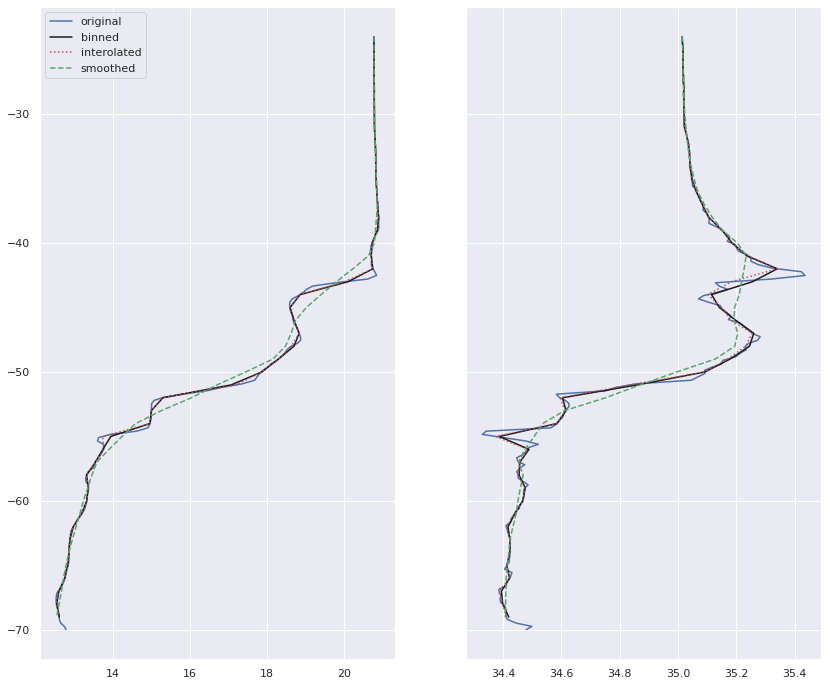

In [26]:
fig, ax = plt.subplots(1,2, figsize=(14, 12), sharey='all')
z = downcast['inshore'].ctdpf_ckl_seawater_pressure[start_idx[0]:end_idx[0]]
t = downcast['inshore'].ctdpf_ckl_seawater_temperature[start_idx[0]:end_idx[0]]
s = downcast['inshore'].practical_salinity[start_idx[0]:end_idx[0]]
ax[0].plot(t, -z, label='original')
ax[1].plot(s, -z)

# Interp/bin profile
keys = 'temp', 'sal'
for i, y in enumerate((t, s)):
    # discretization by grouping    
    out = profile_interp(pres=z, y=y, key=keys[i], start=np.floor(z.min()), 
                         end=np.ceil(z.max()), step=1, method='binning')
    ax[i].plot(out[keys[i]], -out['pres'], '-k', label='binned')

    # discretization by interpolation
    out = profile_interp(pres=z, y=y, key=keys[i], start=np.ceil(z.min()), 
                     end=np.floor(z.max()), step=1, method='interpolate')
    ax[i].plot(out[keys[i]], -out['pres'], ':r', label='interolated')
    
    # discretization and smoothing
    out = profile_interp(pres=z, y=y, key=keys[i], start=np.floor(z.min()), 
                         end=np.ceil(z.max()), step=1, method='binning', filt_profile=True)
    ax[i].plot(out[keys[i]], -out['pres'], '--g', label='smoothed')

ax[0].legend()

### Sorting profs into 2D arrays with equal depth range

In [202]:
def grid_data(ds,loc):
    """
        Put individual profiles into 2D array
        :param: dataset, i.e. either ds, upcast or fullcast
        :param: which location to use
        
        :output: sal,temp,dates(num),dates(datetime),depth(pressure)
    """
    sal = []
    temp = []
    depth = []
    dates = []
    dates2 = []
    append_s = sal.append
    append_t = temp.append
    append_d = dates.append
    append_datetime = dates2.append

    for i, (sidx, eidx) in enumerate(zip(start_idx, end_idx)):
        s = ds[loc].practical_salinity[sidx:eidx+1]
        t = ds[loc].ctdpf_ckl_seawater_temperature[sidx:eidx+1]
        z = ds[loc].ctdpf_ckl_seawater_pressure[sidx:eidx+1]

        p = (100 * i + 1) / start_idx.size
#         if z.size < 10:
#             if p % 5 < 0.1:
#                 print(f'Start: {sidx:>6} | End: {eidx:>6} | ArrayLen: {t.size:>4} | Skip | {p:.2f}%')
#             continue
#         if p % 5 < 0.1:
#             print(f'Start: {sidx:>6} | End: {eidx:>6} | ArrayLen: {t.size:>4} | {p:.2f}%')
        append_d(ds[loc].coords['time'][sidx:eidx+1].astype('float').values.mean())
        append_datetime(ds[loc].coords['time'][sidx:eidx+1].mean().values)

        # Interp/bin profile
        # discretization by grouping    
        out_s = profile_interp(pres=z, y=s, key='sal')
        append_s(out_s['sal'])
        if sidx == 0:
            depth = out_s['pres']
        out_t = profile_interp(pres=z, y=t, key='temp')
        append_t(out_t['temp'])


    sal = np.array(sal).T
    temp = np.array(temp).T
    dates = np.repeat(np.array(dates).reshape(1, -1), sal.shape[0], axis=0)
    depth = np.repeat(np.array(depth).reshape(-1, 1), sal.shape[1], axis=1)
#     print(sal, sal.shape, temp.shape, dates.shape, depth.shape);
    return sal,temp,dates,dates2,depth

In [217]:
dates2

[numpy.datetime64('2019-10-06T15:03:42.574036562'),
 numpy.datetime64('2019-10-06T18:18:34.462174942'),
 numpy.datetime64('2019-10-06T21:18:35.959563224'),
 numpy.datetime64('2019-10-07T00:18:39.472222225'),
 numpy.datetime64('2019-10-07T03:18:45.469387756'),
 numpy.datetime64('2019-10-07T06:18:41.932185667'),
 numpy.datetime64('2019-10-07T09:18:44.479452056'),
 numpy.datetime64('2019-10-07T12:18:40.458333333'),
 numpy.datetime64('2019-10-07T15:18:36.471830985'),
 numpy.datetime64('2019-10-07T18:18:41.800141923'),
 numpy.datetime64('2019-10-07T21:18:45.338306020'),
 numpy.datetime64('2019-10-08T00:18:45.265905712'),
 numpy.datetime64('2019-10-08T03:18:46.949776784'),
 numpy.datetime64('2019-10-08T06:18:45.459276016'),
 numpy.datetime64('2019-10-08T09:18:39.985404899'),
 numpy.datetime64('2019-10-08T12:18:38.422227716'),
 numpy.datetime64('2019-10-08T15:18:37.390160179'),
 numpy.datetime64('2019-10-08T18:18:42.515301568'),
 numpy.datetime64('2019-10-08T21:18:38.654252020'),
 numpy.datet

In [195]:
sal,temp,dates,dates2,depth = grid_data(downcast,'inshore')

Start:      0 | End:    179 | ArrayLen:  180 | 0.00%
Start:    180 | End:    347 | ArrayLen:  168 | 0.04%
Start:    348 | End:    514 | ArrayLen:  167 | 0.08%
Start:   4194 | End:   4196 | ArrayLen:    3 | Skip | 5.04%
Start:   4197 | End:   4200 | ArrayLen:    4 | Skip | 5.08%
Start:   5245 | End:   5245 | ArrayLen:    1 | Skip | 10.03%
Start:   5246 | End:   5248 | ArrayLen:    3 | Skip | 10.07%
Start:   6328 | End:   6332 | ArrayLen:    5 | Skip | 15.03%
Start:   6333 | End:   6335 | ArrayLen:    3 | Skip | 15.07%
Start:   7066 | End:   7069 | ArrayLen:    4 | Skip | 20.03%
Start:   7070 | End:   7073 | ArrayLen:    4 | Skip | 20.07%
Start:   7787 | End:   7790 | ArrayLen:    4 | Skip | 25.02%
Start:   7791 | End:   7792 | ArrayLen:    2 | Skip | 25.06%
Start:   8592 | End:   8596 | ArrayLen:    5 | Skip | 30.02%
Start:   8597 | End:   8599 | ArrayLen:    3 | Skip | 30.06%
Start:   8600 | End:   8602 | ArrayLen:    3 | Skip | 30.10%
Start:   9188 | End:   9193 | ArrayLen:    6 | Ski

## Plot 2D field

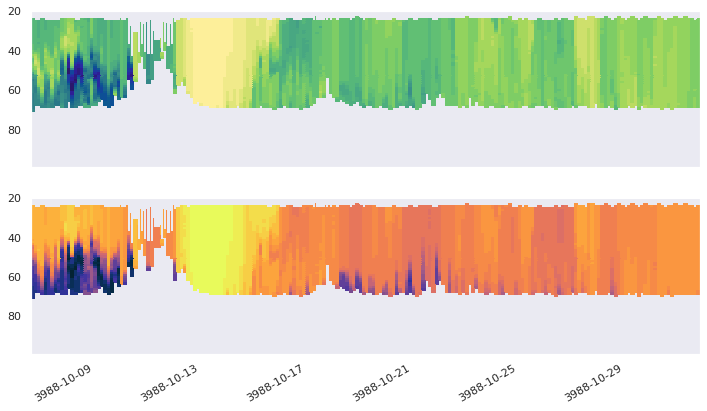

In [221]:
fig, ax = plt.subplots(2,1, figsize=(12, 7), sharex='all')
ax[0].pcolormesh(dates2, depth, np.ma.masked_where(np.isnan(sal), sal),
                 cmap = plt.get_cmap('cmo.haline',30))
ax[0].set_ylim(depth.min(), depth.max())
ax[0].invert_yaxis()
ax[1].pcolormesh(dates2, depth, np.ma.masked_where(np.isnan(temp), temp), 
                 cmap=plt.get_cmap('cmo.thermal',30))
ax[1].set_ylim(depth.min(), depth.max())
ax[1].invert_yaxis()
fig.autofmt_xdate()


# Write 2D numpy array to xarray

In [224]:
def write_xarray(loc):
    sal,temp,dates,dates2,depth = grid_data(downcast,'inshore')
    ds_xr = xr.DataArray(temp, dims=("depth", "time"), coords={"time": dates2, "depth" :depth[:,0]}).to_dataset(name='temp')
    ds_xr['sal'] = (('depth','time'),sal) 
    return ds_xr

# xr_inshore = write_xarray('inshore')
# xr_central_inshore = write_xarray('central_inshore')
# xr_offshore = write_xarray('offshore')
# xr_central_offshore = write_xarray('central_offshore')

In [232]:
downcast['offshore']

KeyError: 'offshore'

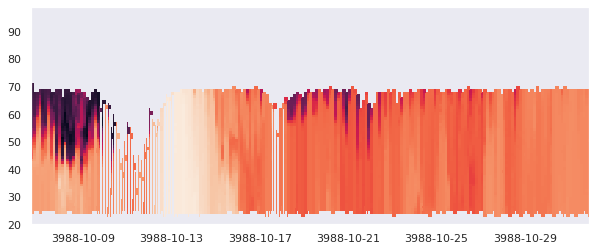

In [229]:
plt.figure(figsize=(10,4))
plt.pcolormesh(xr_inshore.time,xr_inshore.depth,xr_inshore['temp'])

In [208]:
xr_inshore.to_netcdf('inshore_downcast_2D.nc')

In [209]:
xr_central_inshore.to_netcdf('central_inshore_downcast_2D.nc')